In [1]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
from __future__ import division

In [3]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [4]:
# Load the Data

# Set train and valid directory paths

dataset = 'casia-data'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
#num_classes = len(os.listdir(valid_directory))-1  #10#2#257
#num_classes = len(os.listdir(valid_directory)) #10#2#257
num_classes = 2
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

items = iter(train_data_loader)
image, label = items.next()

2
{0: 'Female', 1: 'Male'}


In [5]:
train_data_size, valid_data_size, test_data_size

(18802, 7771, 4512)

In [6]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(40,40))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


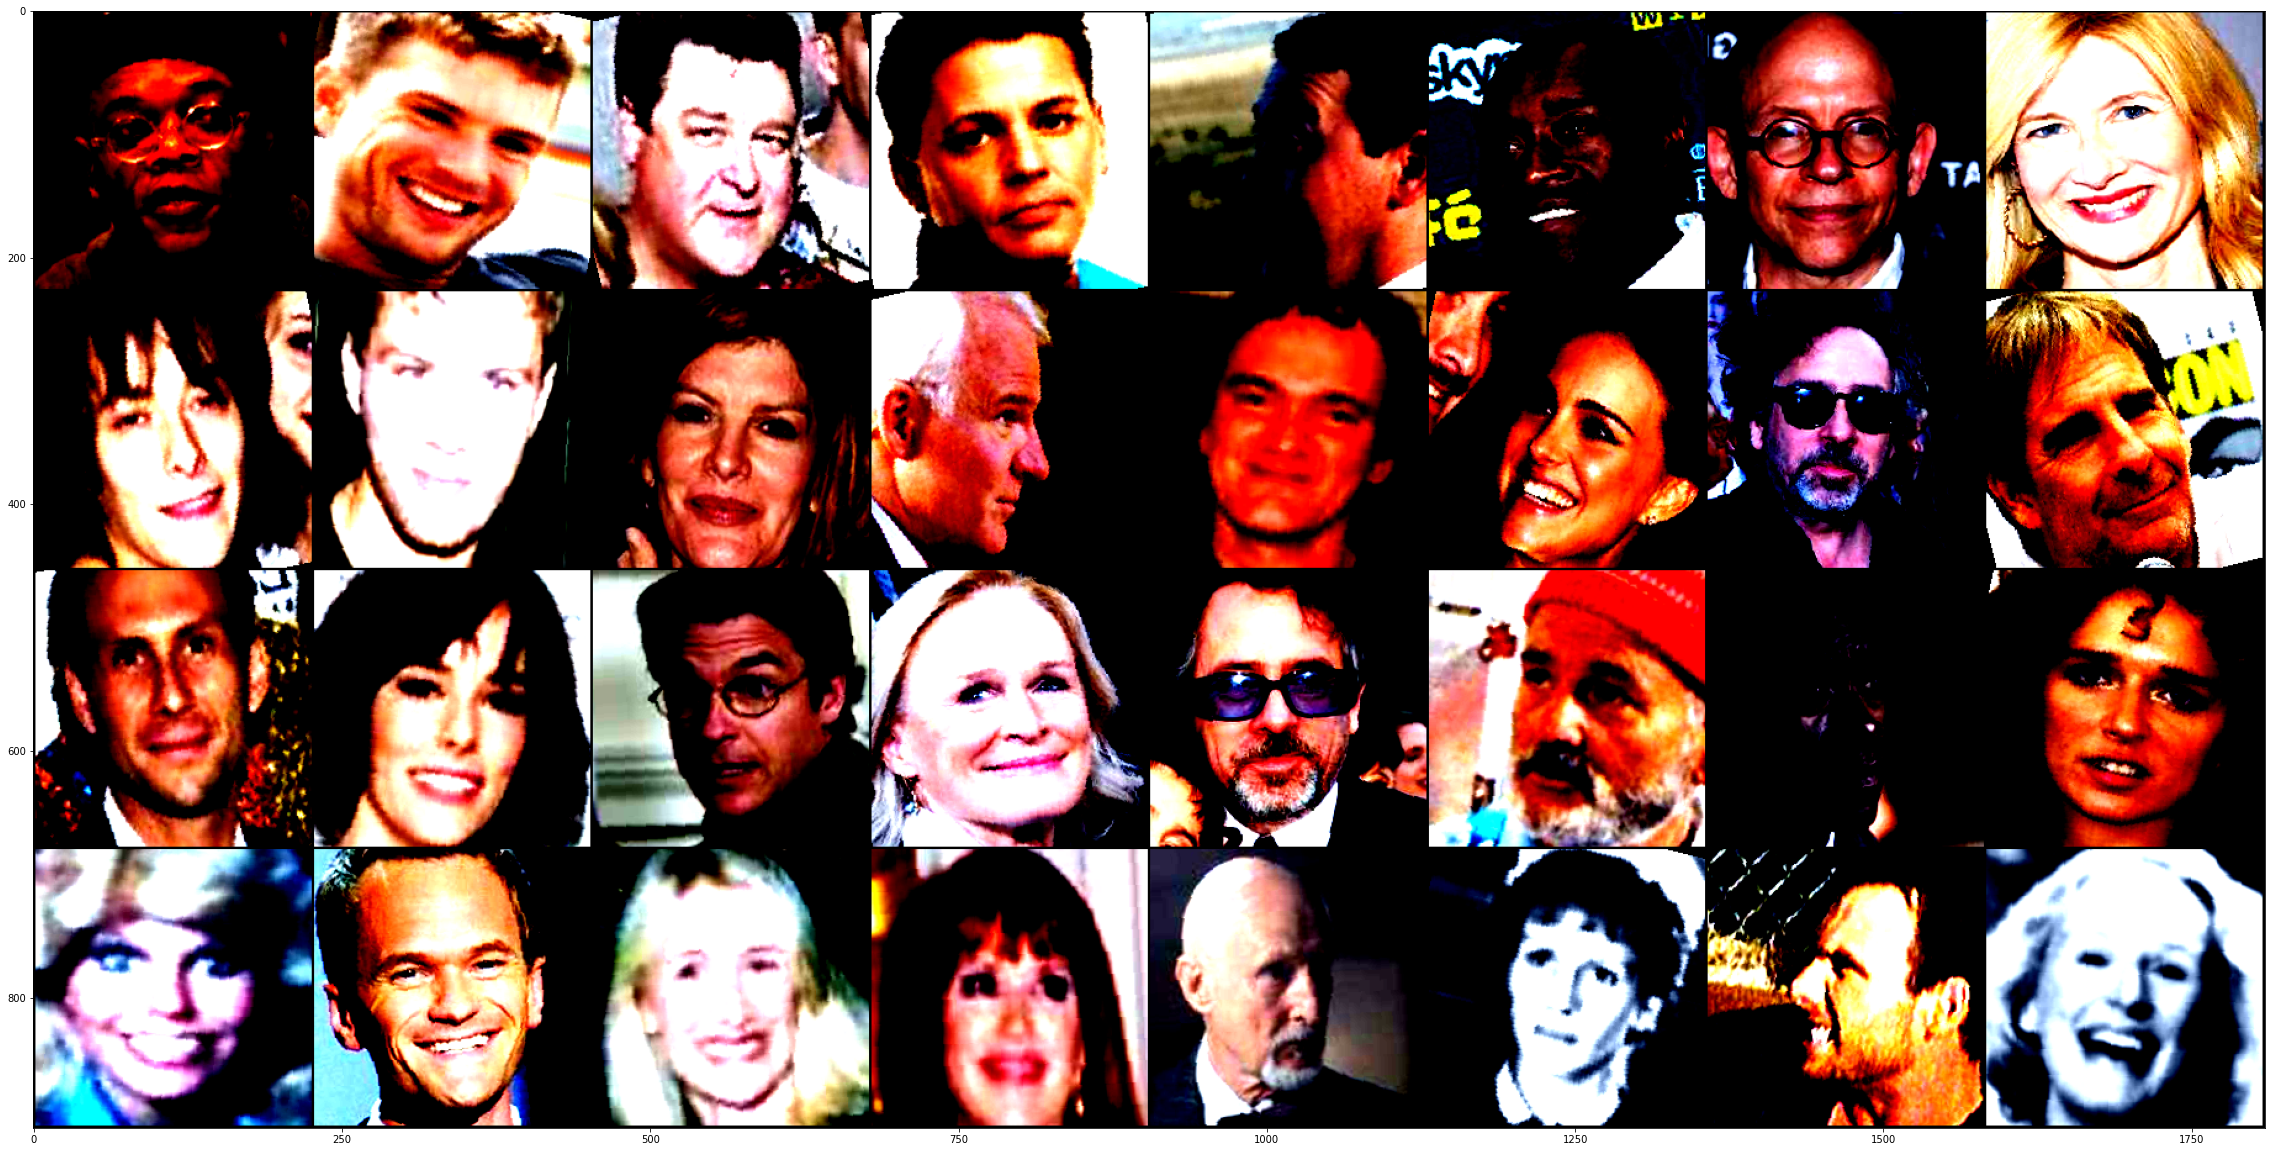

In [7]:
from torchvision.utils import make_grid
show_transformed_image(make_grid(image))

In [8]:
# Load pretrained ResNet50 Model

model_conv = torchvision.models.resnet50(pretrained='imagenet')
model_conv.cuda()
#resnet50 = resnet50.to('cuda:0')

for name, child in model_conv.named_children():
    for name2, params in child.named_parameters():
        print(name, name2)


conv1 weight
bn1 weight
bn1 bias
layer1 0.conv1.weight
layer1 0.bn1.weight
layer1 0.bn1.bias
layer1 0.conv2.weight
layer1 0.bn2.weight
layer1 0.bn2.bias
layer1 0.conv3.weight
layer1 0.bn3.weight
layer1 0.bn3.bias
layer1 0.downsample.0.weight
layer1 0.downsample.1.weight
layer1 0.downsample.1.bias
layer1 1.conv1.weight
layer1 1.bn1.weight
layer1 1.bn1.bias
layer1 1.conv2.weight
layer1 1.bn2.weight
layer1 1.bn2.bias
layer1 1.conv3.weight
layer1 1.bn3.weight
layer1 1.bn3.bias
layer1 2.conv1.weight
layer1 2.bn1.weight
layer1 2.bn1.bias
layer1 2.conv2.weight
layer1 2.bn2.weight
layer1 2.bn2.bias
layer1 2.conv3.weight
layer1 2.bn3.weight
layer1 2.bn3.bias
layer2 0.conv1.weight
layer2 0.bn1.weight
layer2 0.bn1.bias
layer2 0.conv2.weight
layer2 0.bn2.weight
layer2 0.bn2.bias
layer2 0.conv3.weight
layer2 0.bn3.weight
layer2 0.bn3.bias
layer2 0.downsample.0.weight
layer2 0.downsample.1.weight
layer2 0.downsample.1.bias
layer2 1.conv1.weight
layer2 1.bn1.weight
layer2 1.bn1.bias
layer2 1.conv2.we

In [ ]:
#similary for training other pretrained models just pick that model from pytorch model zoo

#some examples are provided below

#model_conv = torchvision.models.alexnet(pretrained='imagenet')
#model_conv = torchvision.models.resnet101(pretrained='imagenet')
#model_conv = torchvision.models.densenet201(pretrained='imagenet')
#model_conv = torchvision.models.densenet121(pretrained='imagenet')

In [9]:
# Freeze or unfreeze the model parameters using false and true command
for param in model_conv.parameters():
    param.requires_grad = True

In [10]:
# Change the final layer of ResNet50 Model for Transfer Learning

num_ftrs = model_conv.fc.in_features
 
model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
model_conv = model_conv.to('cuda:0')

#model_conv.cuda()
# Number of filters in the bottleneck layer
#num_ftrs = model_conv.classifier[6].in_features# convert all the layers to list and remove the last one
#features = list(model_conv.classifier.children())[:-1]## Add the last layer based on the num of classes in our dataset
#features.extend([nn.Linear(num_ftrs, num_classes)])## convert it into container and add it to our model class.
#model_conv.classifier = nn.Sequential(*features)


In [11]:
# Define Optimizer and Loss Function
#loss_func = nn.NLLLoss() # For using nn-loss
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.Adam(resnet50.parameters()) # For using Adam optimizer
optimizer = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [12]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

# Print the model to be trained
#summary(model_conv, input_data=(3, 224, 224), batch_size=bs, device="cuda")
summary(model_conv, (3, 250, 250))

# Train the model for 25 epochs
num_epochs = 100
trained_model, history = train_and_validate(model_conv, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

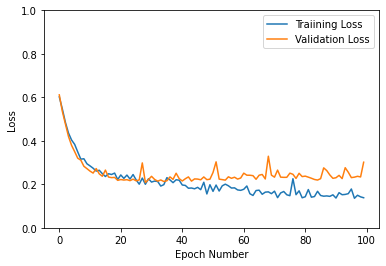

In [35]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Traiining Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


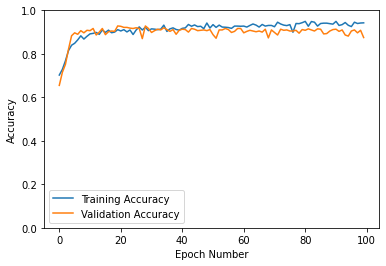

In [36]:
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [76]:
import torch

model_conv.eval()
test_acc_count = 0
for k, (test_images, test_labels) in enumerate(test_data_loader):
    model = torch.load('enter your model name')
    model.cpu()
    #test_outputs = model_conv(test_images)
    test_outputs = model(test_images)
    _, prediction = torch.max(test_outputs.data, 1)
    test_acc_count += torch.sum(prediction == test_labels.data).item()
    
a = test_acc_count
print (a) 

b = test_data_size
print (b)
test_accuracy = (a / b)*100

80
90


In [51]:
print ('The total test accuracy of the system is')
print (test_accuracy)

The total test accuracy of the system is
88.88888888888889
